# Libraries

In [1]:
import torch
import torchvision
from torchvision import utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import sys
import numpy as np
import os
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sn

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_dir = "Images/PA2_"

# Utility Functions

Code taken from tutorial

In [2]:
def pbar(p=0, msg="", bar_len=20):
    sys.stdout.write("\033[K")
    sys.stdout.write("\x1b[2K" + "\r")
    block = int(round(bar_len * p))
    text = "Progress: [{}] {}% {}".format(
        "\x1b[32m" + "=" * (block - 1) + ">" + "\033[0m" + "-" * (bar_len - block),
        round(p * 100, 2),
        msg,
    )
    print(text, end="\r")
    if p == 1:
        print()

class AvgMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.metrics = {}

    def add(self, batch_metrics):
        if self.metrics == {}:
            for key, value in batch_metrics.items():
                self.metrics[key] = [value]
        else:
            for key, value in batch_metrics.items():
                self.metrics[key].append(value)

    def get(self):
        return {key: np.mean(value) for key, value in self.metrics.items()}

    def msg(self):
        avg_metrics = {key: np.mean(value) for key, value in self.metrics.items()}
        return "".join(["[{}] {:.5f} ".format(key, value) for key, value in avg_metrics.items()])

def train(model, optim, lr_sched=None, epochs=200, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), criterion=None, metric_meter=None, out_dir="out/"):
  model.to(device)
  best_acc = 0
  for epoch in range(epochs):
    model.train()
    metric_meter.reset()
    for indx, (img, target) in enumerate(train_loader):
      img = img.to(device)
      target = target.to(device)
      
      optim.zero_grad()
      out = model.forward(img)
      loss = criterion(out, target)
      loss.backward()
      optim.step()

      metric_meter.add({"train loss": loss.item()})
      pbar(indx / len(train_loader), msg=metric_meter.msg())
    pbar(1, msg=metric_meter.msg())
    train_loss_for_plot.append(metric_meter.get()["train loss"])
    
    model.eval()
    metric_meter.reset()
    for indx, (img, target) in enumerate(val_loader):
      img = img.to(device)
      target = target.to(device)
      out = model.forward(img)
      loss = criterion(out, target)
      acc = (out.argmax(1) == target).sum().item() * (100 / img.shape[0])

      metric_meter.add({"val loss": loss.item(), "val acc": acc})
      pbar(indx / len(val_loader), msg=metric_meter.msg())
    pbar(1, msg=metric_meter.msg())
    
    val_metrics = metric_meter.get()
    val_loss_for_plot.append(val_metrics["val loss"])
    val_acc_for_plot.append(val_metrics["val acc"])
    if val_metrics["val acc"] > best_acc:
      print(
          "\x1b[33m"
          + f"val acc improved from {round(best_acc, 5)} to {round(val_metrics['val acc'], 5)}"
          + "\033[0m"
      )
      best_acc = val_metrics['val acc']
      torch.save(model.state_dict(), os.path.join(out_dir, "best.ckpt"))
    lr_sched.step()

# Data Loading

In [3]:
data_train = datasets.MNIST('~/mnist_data', train=True, download=True, transform=transforms.ToTensor())
data_test = datasets.MNIST('~/mnist_data', train=False, download=True, transform=transforms.ToTensor())

60000


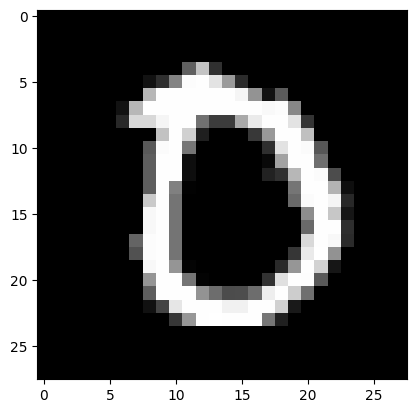

In [4]:
plt.imshow(data_train[np.random.randint(len(data_train))][0][0], cmap='gray')
print(len(data_train))

In [5]:
# Split train data into train(80%) and validation(20%)
# Also ensures that class representation remains same.

train_indices, val_indices, _, _ = train_test_split(
    range(len(data_train)),
    data_train.targets,
    stratify=data_train.targets, # Make sure that the percentage of each class is same in both train & val
    test_size=int(0.2 * len(data_train)),
)

train_split = Subset(data_train, train_indices)
val_split = Subset(data_train, val_indices)

In [6]:
BATCH_SIZE = 64
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_split, batch_size=BATCH_SIZE)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE)

# Part 1: MNIST Classification using CNN

In [7]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.fc1   = nn.Linear(32 * 7 * 7, 500)
    self.fc2   = nn.Linear(500, 10)
    self.activ = nn.ReLU()
    
#     self.bn1    = nn.BatchNorm2d(32)
#     self.bn2    = nn.BatchNorm2d(32)
    

  def forward(self, x):
    out = self.activ(self.conv1(x))
    out = self.pool1(out)
#     out = self.bn1(out)
    out = self.activ(self.conv2(out))
    out = self.pool2(out)
#     out = self.bn2(out)
    out = nn.Flatten()(out)
    out = self.activ(self.fc1(out))
    out = self.fc2(out) # No need to take softmax here because CrossEntropyLoss
                        # combines nn.LogSoftmax() and nn.NLLLoss() in one single class """
    return out

## Training

In [ ]:
model = MyModel()
epochs = 15
optim = torch.optim.SGD(model.parameters(), lr=10**(-1.5), momentum=0.9, weight_decay=5e-4)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)
criterion = nn.CrossEntropyLoss()
metric_meter = AvgMeter()
# out_dir = "MyModel_BatchNorm"
out_dir = "MyModel"
os.makedirs(out_dir, exist_ok=True)

train_loss_for_plot = []
val_loss_for_plot = []
val_acc_for_plot = []

train(model, optim, lr_sched, epochs=epochs, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir)
# After this the model will be saved

In [ ]:
X = [i+1 for i in range(epochs)]

plt.plot(X, train_loss_for_plot); plt.ylabel('Train Loss'); plt.xlabel('Epoch')
plt.savefig(img_dir + "train_loss.svg"); plt.clf();

plt.plot(X, val_loss_for_plot); plt.ylabel('Validation Loss'); plt.xlabel('Epoch')
plt.savefig(img_dir + "val_loss.svg"); plt.clf();

plt.plot([0] + X, [0] + val_acc_for_plot); plt.ylabel('Validation Accuracy'); plt.xlabel('Epoch')
plt.savefig(img_dir + "val_acc.svg"); plt.clf();

## Testing

In [8]:
best_ckpt = torch.load("MyModel/best.ckpt")
# best_ckpt = torch.load("MyModel_BatchNorm/best.ckpt")
model_saved = MyModel()
model_saved.load_state_dict(best_ckpt)
model_saved.to(torch.device("cuda"))

l = []
for indx, (img, target) in enumerate(test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img = img.to(device)
    target = target.to(device)
    out = model_saved.forward(img)
    acc = (out.argmax(1) == target).sum().item() * (100 / img.shape[0])
    l.append(acc)
print("Average test accuracy is:", np.mean(l))

Average test accuracy is: 99.18391719745223


## Random Verification

In [ ]:
plt.figure(figsize = (15, 7))
for idx in range(10):
    rand_sample = np.random.randint(len(data_test))
    img = data_test[rand_sample][0][0]
    act = str(data_test[rand_sample][1])
    pred = str(model_saved.forward(img.view(1,1,28,28).to(device)).argmax(1).item())
    plt.subplot(2, 5, idx+1)
    plt.imshow(img, cmap='gray'); plt.axis('off'); plt.ioff()
    plt.title('True: ' + act + '\nPrediction: ' + pred, fontsize = 20, fontweight='bold', color = 'blue')
plt.savefig(img_dir + 'random_ver.svg'); plt.clf()

# Part 2: Visualising the CNN

In [ ]:
print(model_saved)

## Filter Visualisation

In [ ]:
# Reference: https://stackoverflow.com/a/55604568
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=1)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

model_children = list(model_saved.children())
filter1 = model_children[0].weight.data.clone().to(torch.device("cpu"))
filter2 = model_children[1].weight.data.clone().to(torch.device("cpu"))

visTensor(filter1); plt.axis('off'); plt.ioff()
plt.savefig(img_dir + 'conv1_filters.png', dpi = 150); plt.clf()

visTensor(filter2); plt.axis('off'); plt.ioff()
plt.savefig(img_dir + 'conv2_filters.png', dpi = 150); plt.clf()

In [9]:
def getImage(ACTUAL_CLASS):
    image = None
    for i in range(len(data_train)):
        if(data_train[i][1] == ACTUAL_CLASS):
            image = data_train[i][0].to(device)
            break
    assert(image != None)
    return image

## Activation Visualisation

In [ ]:
plt.clf()
plt.figure(figsize = (5, 2))
for ACTUAL_CLASS in range(10):
    image = getImage(ACTUAL_CLASS).view(1, 1, 28, 28)

    fmap1 = model_saved.activ(model_saved.conv1(image))
    
    plt.subplot(2, 5, ACTUAL_CLASS + 1)
    visTensor(fmap1.to(torch.device('cpu'))); plt.axis('off'); plt.ioff()
plt.savefig(img_dir + 'activ1.svg'); plt.clf()

plt.clf()
plt.figure(figsize = (5, 2))
for ACTUAL_CLASS in range(10):
    image = None
    for i in range(len(data_train)):
        if(data_train[i][1] == ACTUAL_CLASS):
            image = data_train[i][0].to(device)
            break
    assert(image != None)
    image = image.view(1, 1, 28, 28)


    out = model_saved.activ(model_saved.conv1(image))
    out = model_saved.pool1(out)
    fmap2 = model_saved.activ(model_saved.conv2(out))
    
    plt.subplot(2, 5, ACTUAL_CLASS + 1)
    
    visTensor(fmap2.to(torch.device('cpu'))); plt.axis('off'); plt.ioff()
plt.savefig(img_dir + 'activ2.svg'); plt.clf()

## Occlusion

In [ ]:
# Reference: https://www.kaggle.com/code/blargl/simple-occlusion-and-saliency-maps/notebook
def occlusion_list(image, occ_size, occ_val = 0.5):
    
    assert(occ_size <= image.shape[0])
    assert(occ_size % 2 == 1) # Only odd size occlusion
    
    occlusion = np.full((occ_size, occ_size), [occ_val], np.float32)
    occ_list = []
    
    for x in range(occ_size, image.shape[0] + occ_size):
        for y in range(occ_size, image.shape[1] + occ_size):
            image_copy = np.pad(image, ((occ_size, occ_size), (occ_size, occ_size)), 'constant', constant_values = 0.0).copy()
            
            image_copy[x - occ_size // 2 : x + occ_size // 2 + 1, \
                       y - occ_size // 2 : y + occ_size // 2 + 1] = occlusion
            
            occ_list.append((x - occ_size, y - occ_size, image_copy[occ_size:occ_size+image.shape[0], occ_size:occ_size+image.shape[1]]))
            
    return occ_list

In [ ]:
sample_size = 10

np.random.seed(1234567)
idx = [np.random.randint(len(data_train)) for _ in range(sample_size)]
images = [data_train[idx[i]][0].detach().clone() for i in range(sample_size)]

plt.clf()
plt.figure(figsize=(8, 10))
for i, img in enumerate(images):
    plt.subplot(5, 4, 2 * i + 1)
    plt.imshow(img[0], cmap='gray'); plt.axis('off'); plt.ioff();
            
    sz = img[0].shape[0]
    heat_map = np.zeros((sz,sz))
    occ_list = occlusion_list(img[0], occ_size = 7, occ_val = 0)
    
    for (x, y, img_occ) in occ_list:
        img_occ = img_occ.reshape(1, 1, sz, sz)
        img_occ = torch.Tensor(img_occ).to(device)
        out = nn.Softmax(dim=1)(model_saved.forward(img_occ))
        heat_map[x, y] = out[0, data_train[idx[i]][1]]

    plt.subplot(5, 4, 2 * i + 2)
    sn.heatmap(heat_map)

plt.savefig(img_dir + 'occ_7.svg'); plt.clf()

# Part 3: Adversial Examples

## 3.1 Non Targeted Attack

In [ ]:
MEAN = 0.5
STD = 0.1

gen_imgs = []
cost_lists = []
for TARGET_CLASS in range(10):
    gen_img = torch.normal(MEAN, STD, size=(1, 1, 28, 28)).to(device)
    gen_img.requires_grad = True

    optim_adv = torch.optim.SGD([gen_img], lr=10**-2)

    epochs = 500
    cost_list = []
    for i in range(epochs):
        optim_adv.zero_grad()
        C = -model_saved.forward(gen_img)[0, TARGET_CLASS]
        cost_list.append(-C.to(torch.device('cpu')).detach().clone())
        C.backward()
        optim_adv.step()
    cost_lists.append(cost_list)
    gen_imgs.append(gen_img)

    out = model_saved.forward(gen_img)
    print("Probability", nn.Softmax(dim=1)(out)[0][TARGET_CLASS])

plt.figure(figsize = (20, 4))
for cls in range(10):
    plt.subplot(2, 5, cls + 1)
    epochs = len(cost_lists[cls])
    X = [i for i in range(epochs)]
    Y = [cost_lists[cls][i] for i in range(epochs)]
    plt.plot(X, Y)
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
# plt.show(); plt.clf()
plt.savefig(img_dir + 'cost_vs_epochs_3_1.svg'); plt.clf()


plt.figure(figsize = (10, 3.5))
for cls in range(10):
    plt.subplot(2, 5, cls+1)
    plt.imshow(gen_imgs[cls][0][0].to(torch.device('cpu')).detach(), cmap = 'gray');
    plt.axis('off'); plt.ioff()
    plt.title('Class ' + str(cls))
# plt.show(); plt.clf()
plt.savefig(img_dir + 'gen_images_3_1.svg'); plt.clf()

## 3.2 Targeted Attack

In [22]:
TARGET_CLASS = 3
BETA = 10**-3
ALPHA = 10**-1
MEAN = 0.5
STD = 0.1

gen_imgs = []
for ACTUAL_CLASS in range(10):
    targetImage = getImage(ACTUAL_CLASS)

    gen_img = torch.normal(MEAN, STD, size=(1, 1, 28, 28)).to(device)
#     gen_img = targetImage.detach().clone().view(1, 1, 28, 28)
    gen_img.requires_grad = True

    optim_adv = torch.optim.SGD([gen_img], lr=ALPHA)
    
    pred_class = 11
    epochs = 200
    for i in range(epochs):
#     while(pred_class != TARGET_CLASS):
        optim_adv.zero_grad()
        C = - (model_saved.forward(gen_img)[0, TARGET_CLASS] - BETA * nn.MSELoss()(gen_img[0], targetImage))
        C.backward()
        optim_adv.step()
        pred_class = model_saved.forward(gen_img).argmax(1)

    assert(pred_class == TARGET_CLASS)
    gen_imgs.append(gen_img)

plt.figure(figsize = (10, 3.5))
for cls in range(10):
    plt.subplot(2, 5, cls+1)
    plt.imshow(gen_imgs[cls][0][0].to(torch.device('cpu')).detach(), cmap = 'gray');
    plt.axis('off'); plt.ioff()
# plt.show(); plt.clf()
plt.savefig(img_dir + 'gen_images_3_2.svg'); plt.clf()

## Adding Noise

In [10]:
TARGET_CLASS = 3
ALPHA = 10**-2

gen_imgs = []
noises = []
for ACTUAL_CLASS in range(10):
    targetImage = getImage(ACTUAL_CLASS)

    noise = torch.zeros(1, 1, 28, 28).to(device)
    noise.requires_grad = True

    optim_adv = torch.optim.SGD([noise], lr=ALPHA)

    pred_class = 11
    while(pred_class != TARGET_CLASS):
        optim_adv.zero_grad()
        C = - (model_saved.forward(targetImage + noise)[0, TARGET_CLASS])
        C.backward()
        optim_adv.step()
        pred_class = model_saved.forward(targetImage + noise).argmax(1)
    gen_imgs.append(targetImage + noise)
    noises.append(noise)
    
plt.figure(figsize = (12, 8))
for cls in range(10):
    plt.subplot(4, 6, 2*cls+1)
    plt.imshow(gen_imgs[cls][0][0].to(torch.device('cpu')).detach(), cmap = 'gray');
    plt.axis('off'); plt.ioff()
    plt.title('Adv Image')
    
    plt.subplot(4, 6, 2*cls+2)
    plt.imshow(noises[cls][0][0].to(torch.device('cpu')).detach(), cmap = 'gray');
    plt.axis('off'); plt.ioff()
    plt.title('Noise')
# plt.show(); plt.clf()
plt.savefig(img_dir + 'gen_images_3_3_1.svg'); plt.clf()

<Figure size 1200x800 with 0 Axes>

In [29]:
# res = []
for ACTUAL_CLASS in range(10):
    
    img = None
    print("ACTUAL CLASS =", ACTUAL_CLASS)
    for i in range(len(data_train)):
        if(data_train[-(i+1)][1] == ACTUAL_CLASS):
            img = data_train[-(i+1)][0].to(device)
            break
    
    act_class = ACTUAL_CLASS
    for idx, noise in enumerate(noises):
        pred_class = int(model_saved.forward(img + noise).argmax(1).detach())
#         res.append((act_class, pred_class))
        print("(noise", idx, "PRED CLASS =", pred_class, ")", end="; ")
        if(idx%3 == 2):
            print()
    print()
# print(res)

ACTUAL CLASS = 0
(noise 0 PRED CLASS = 0 ); (noise 1 PRED CLASS = 0 ); (noise 2 PRED CLASS = 0 ); 
(noise 3 PRED CLASS = 0 ); (noise 4 PRED CLASS = 0 ); (noise 5 PRED CLASS = 0 ); 
(noise 6 PRED CLASS = 0 ); (noise 7 PRED CLASS = 0 ); (noise 8 PRED CLASS = 0 ); 
(noise 9 PRED CLASS = 0 ); 
ACTUAL CLASS = 1
(noise 0 PRED CLASS = 1 ); (noise 1 PRED CLASS = 3 ); (noise 2 PRED CLASS = 1 ); 
(noise 3 PRED CLASS = 1 ); (noise 4 PRED CLASS = 1 ); (noise 5 PRED CLASS = 1 ); 
(noise 6 PRED CLASS = 1 ); (noise 7 PRED CLASS = 1 ); (noise 8 PRED CLASS = 1 ); 
(noise 9 PRED CLASS = 1 ); 
ACTUAL CLASS = 2
(noise 0 PRED CLASS = 2 ); (noise 1 PRED CLASS = 2 ); (noise 2 PRED CLASS = 2 ); 
(noise 3 PRED CLASS = 2 ); (noise 4 PRED CLASS = 2 ); (noise 5 PRED CLASS = 2 ); 
(noise 6 PRED CLASS = 2 ); (noise 7 PRED CLASS = 2 ); (noise 8 PRED CLASS = 2 ); 
(noise 9 PRED CLASS = 2 ); 
ACTUAL CLASS = 3
(noise 0 PRED CLASS = 3 ); (noise 1 PRED CLASS = 3 ); (noise 2 PRED CLASS = 3 ); 
(noise 3 PRED CLASS = 3 ); (